In [2]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxa
import geopandas as gpd
from scipy.optimize import curve_fit

In [4]:
ds = xr.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/GM_cor_vv.nc')

In [6]:
def temp_model(T, tau):
    return np.exp(-T/tau)
    
def tau(cors, days):
    if np.sum(np.isnan(cors)) == 0:
        s = curve_fit(temp_model, days, cors, 5)[0][0]
        return s
    else:
        return np.nan

In [16]:
taus = np.apply_along_axis(arr = ds['cor_vv'].values, func1d = tau, axis = 0, days = days)

In [35]:
coarse = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_coarse.tiff')

In [37]:
coarse.values[0] = taus

In [53]:
dem = rxa.open_rasterio('../../../data/coherence_spatial_GM/gm_dem.tiff')

roads = '/bsuhome/zacharykeskinen/scratch/data/uavsar/roads/Shape/Trans_RoadSegment.shp'
roads = '../../../data/aucillary/roads/Shape/Trans_RoadSegment.shp'
roads = gpd.read_file(roads)
hwy21 = roads[roads.state_ro_1 == '21']
fires = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/mtbs_perimeter_data/mtbs_perims_DD.shp')
water = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_water.shp')
trees = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_trees.shp')
# lc = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/id_16/nlcd_id_utm11.tif')
# lc = lc.rio.reproject_match(dem)
# deep_snow = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/deep_snow.shp')

In [64]:
trees = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/trees_selected.shp')

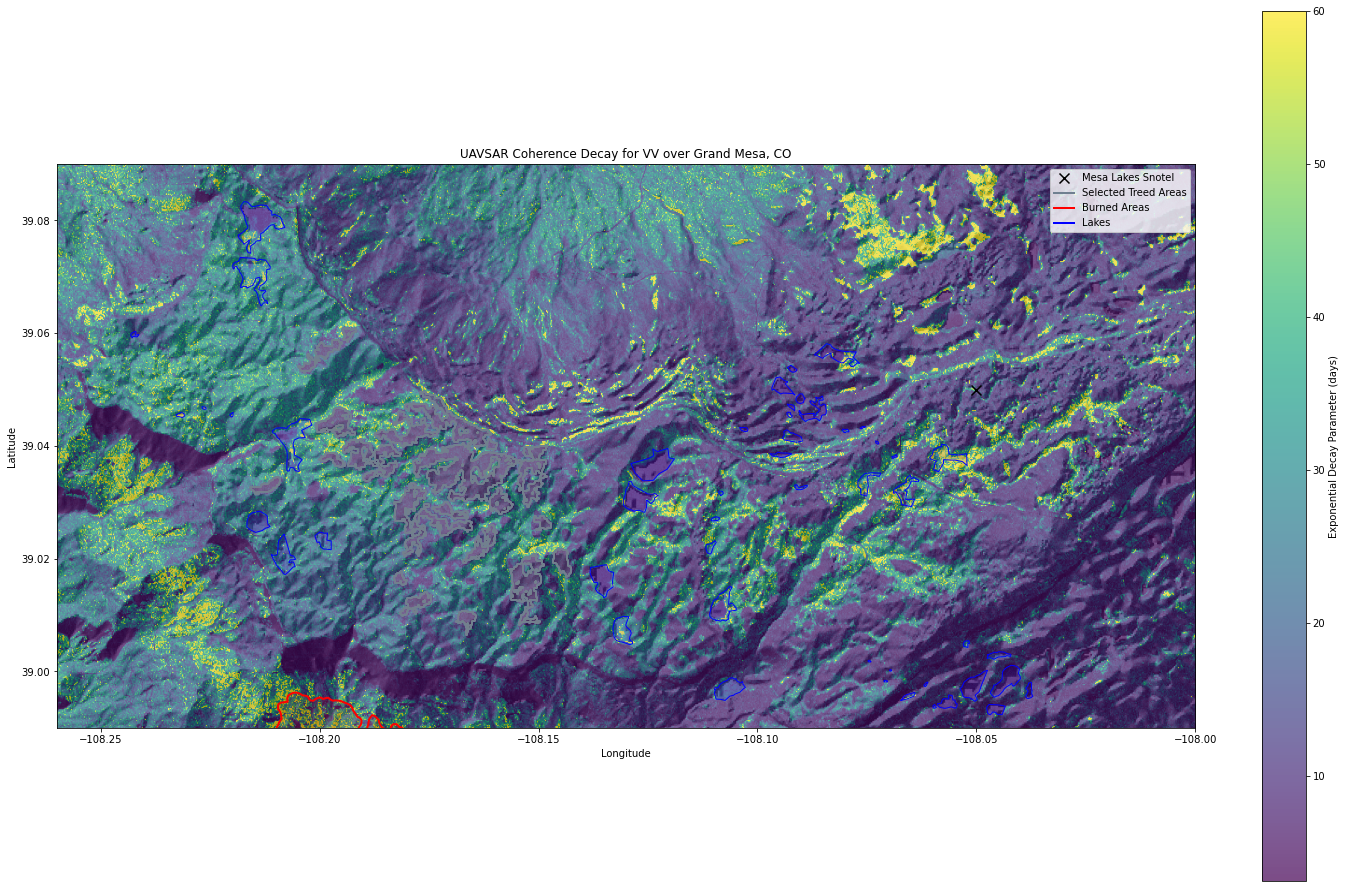

In [66]:
from matplotlib.colors import LightSource
figdir = '/Users/zachkeskinen/Documents/uavsar/figures/coherence_spatial'
fig, ax = plt.subplots(figsize = (24,16))

dx = 0.0005
dy = 0.0005
conversion = 6

ls = LightSource(azdeg = 315, altdeg = 45)
cmap = plt.cm.gist_earth
rgb = ls.hillshade(dem.values[0], vert_exag=10, dx = dx*conversion, dy = dy*conversion)
plt.imshow(rgb, extent = (dem.x.min().data,dem.x.max().data, dem.y.min().data, dem.y.max().data), cmap = 'gray')
plt.imshow(taus, vmax = 60, alpha = 0.7, extent = (dem.x.min().data,dem.x.max().data, dem.y.min().data, dem.y.max().data))
plt.colorbar(fraction = 0.1, label = 'Exponential Decay Parameter (days)')
# add some other pieces
snotel_coords = (-108.05, 39.05)
plt.scatter(*snotel_coords, s = 100, marker = 'x', color = 'black', label = 'Mesa Lakes Snotel')

trees.plot(fc = 'none', ec = 'slategrey', linewidth = 2, ax= ax)
trees.plot(fc = 'grey', ec = 'none', linewidth = 2, ax= ax, alpha = 0.2)
plt.plot([1,1],[1,1], linewidth = 2, color = 'slategrey', label = 'Selected Treed Areas')

fires.plot(ax = ax, fc = 'red', ec ='none', linewidth = 2, alpha = 0.1)
fires.plot(ax = ax, fc = 'none', ec ='red', linewidth = 2, alpha = 1)
plt.plot([1,1],[1,1], linewidth = 2, color = 'red', label = 'Burned Areas')

# deep_snow.plot(ax =ax , fc = 'blue', alpha = 0.1)
# deep_snow.plot(ax =ax , fc = 'none',ec = 'blue', linewidth = 1)
# plt.plot([1,1],[1,1], linewidth = 2, color = 'blue', label = '3+m Snowpack')

water.plot(ax =ax , fc = 'blue', alpha = 0.1)
water.plot(ax =ax , fc = 'none',ec = 'blue', linewidth = 1)
plt.plot([1,1],[1,1], linewidth = 2, color = 'blue', label = 'Lakes')

plt.xlim(-108.26, -108)
plt.ylim(38.99, 39.09)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend()
plt.title('UAVSAR Coherence Decay for VV over Grand Mesa, CO')
plt.savefig(join(figdir, 'tau_VV_GM.png'))